In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks, peak_widths
from mesagrid import Track
import mesa_reader as mr
# import pygyre as pg
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from scipy.ndimage import median_filter, uniform_filter1d
%matplotlib inline

In [2]:
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'axes.linewidth' : 1,
    'ytick.major.width' : 1,
    'ytick.minor.width' : 1,
    'xtick.major.width' : 1,
    'xtick.minor.width' : 1,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    'axes.labelsize': 12,
    'font.family': 'serif',
    'text.usetex': False
})

In [3]:
ID = 'KIC 4552982'

In [4]:
lk = lk.search_lightcurve(f'{ID}', mission = 'Kepler', quarter=14)
lk

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 14,2012,Kepler,60,kplr004552982,0.0
1,Kepler Quarter 14,2012,Kepler,60,kplr004552982,0.0
2,Kepler Quarter 14,2012,Kepler,60,kplr004552982,0.0
3,Kepler Quarter 14,2012,Kepler,1800,kplr004552982,0.0


In [5]:
lc = lk.download_all().stitch()
lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1274.1303406126463,———,———,0,2.859573e-03,443.60125,551.19113,1699180,6.0918646e+02,8.7938442e+00,3.1771924e+02,1.0041720e-01,———,———,0,———,———,———,———,443.60125,2.1928169e-02,551.19113,1.6527703e-02,2.8477326e-02,3.1032607e-02
1274.1310217352293,1.0104601e+00,1.4980722e-02,0,2.859595e-03,443.60065,551.21238,1699181,6.0740033e+02,8.7944841e+00,3.1772299e+02,1.0041291e-01,9.3915540e+02,1.3923584e+01,0,———,———,———,———,443.60065,2.1981999e-02,551.21238,1.6674396e-02,2.8488761e-02,3.1032277e-02
1274.1317027578189,1.0341710e+00,1.5001742e-02,0,2.859618e-03,443.59912,551.18378,1699182,6.2181940e+02,8.8079233e+00,3.1772675e+02,1.0040861e-01,9.6119312e+02,1.3943120e+01,0,———,———,———,———,443.59912,2.2234498e-02,551.18378,1.6746381e-02,2.8500192e-02,3.1031946e-02
1274.1323839804027,9.9356669e-01,1.4962727e-02,0,2.859640e-03,443.60756,551.20253,1699183,5.9717395e+02,8.7832489e+00,3.1773053e+02,1.0040431e-01,9.2345410e+02,1.3906858e+01,0,———,———,———,———,443.60756,2.2980744e-02,551.20253,1.7380845e-02,2.8511629e-02,3.1031616e-02
1274.1330651029857,9.8337257e-01,1.4953562e-02,0,2.859663e-03,443.61135,551.21043,1699184,5.9099786e+02,8.7775192e+00,3.1773428e+02,1.0040002e-01,9.1397931e+02,1.3898340e+01,0,———,———,———,———,443.61135,2.2497555e-02,551.21043,1.7019516e-02,2.8523061e-02,3.1031286e-02
1274.1337462255688,9.8669481e-01,1.4955683e-02,0,2.859686e-03,443.63975,551.22904,1699185,5.9303021e+02,8.7789488e+00,3.1773804e+02,1.0039572e-01,9.1706714e+02,1.3900311e+01,0,———,———,———,———,443.63975,2.3119980e-02,551.22904,1.7552631e-02,2.8534496e-02,3.1030955e-02
1274.1344274481526,9.9749058e-01,1.4966057e-02,0,2.859708e-03,443.64452,551.21324,1699186,5.9960083e+02,8.7856112e+00,3.1774182e+02,1.0039144e-01,9.2710107e+02,1.3909953e+01,0,———,———,———,———,443.64452,2.2613429e-02,551.21324,1.7075140e-02,2.8545931e-02,3.1030625e-02
1274.1351085705028,9.8416764e-01,1.4951858e-02,0,2.859731e-03,443.65270,551.20252,1699187,5.9152142e+02,8.7766705e+00,3.1774554e+02,1.0038715e-01,9.1471826e+02,1.3896756e+01,0,———,———,———,———,443.65270,2.2854686e-02,551.20252,1.7204443e-02,2.8557364e-02,3.1030294e-02


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

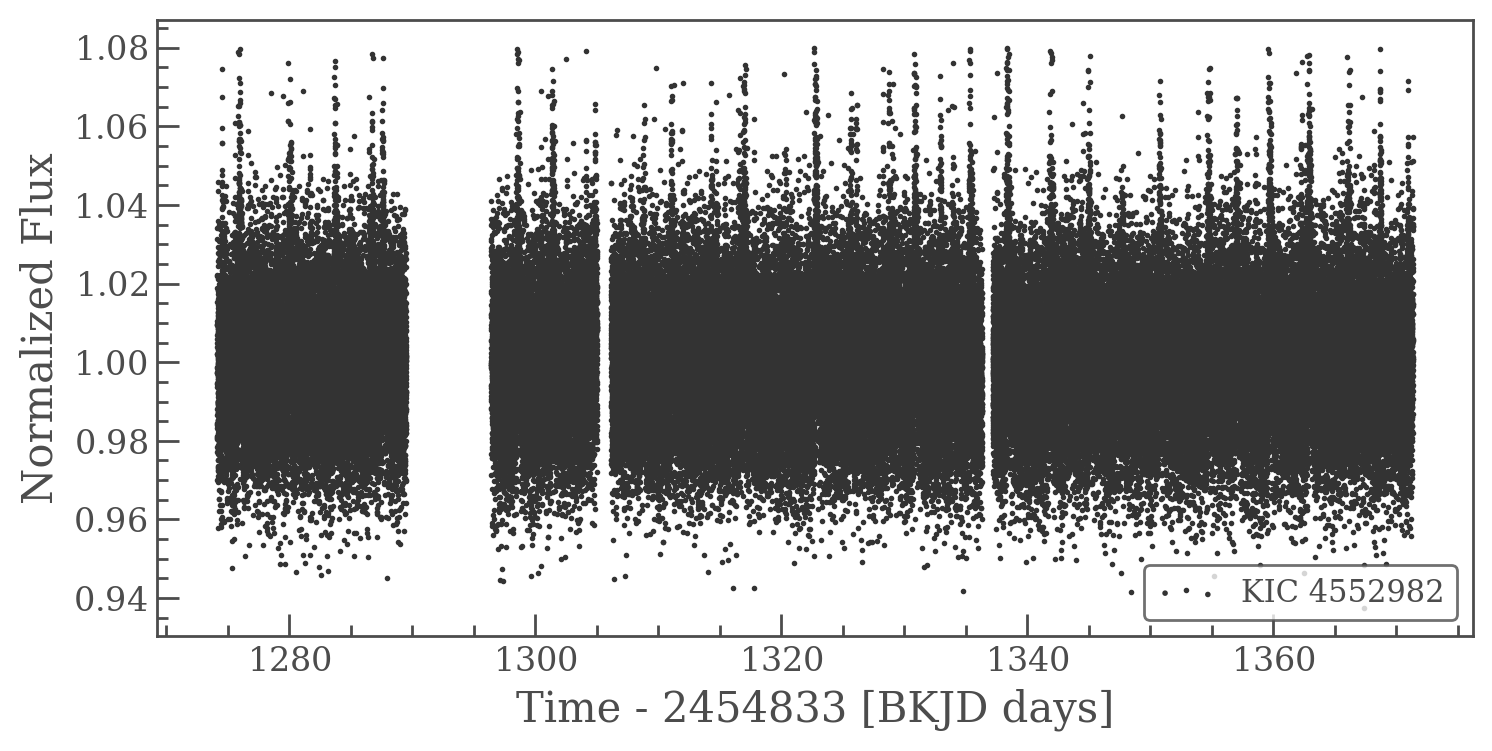

In [6]:
lc = lc.remove_outliers()
lc.scatter()

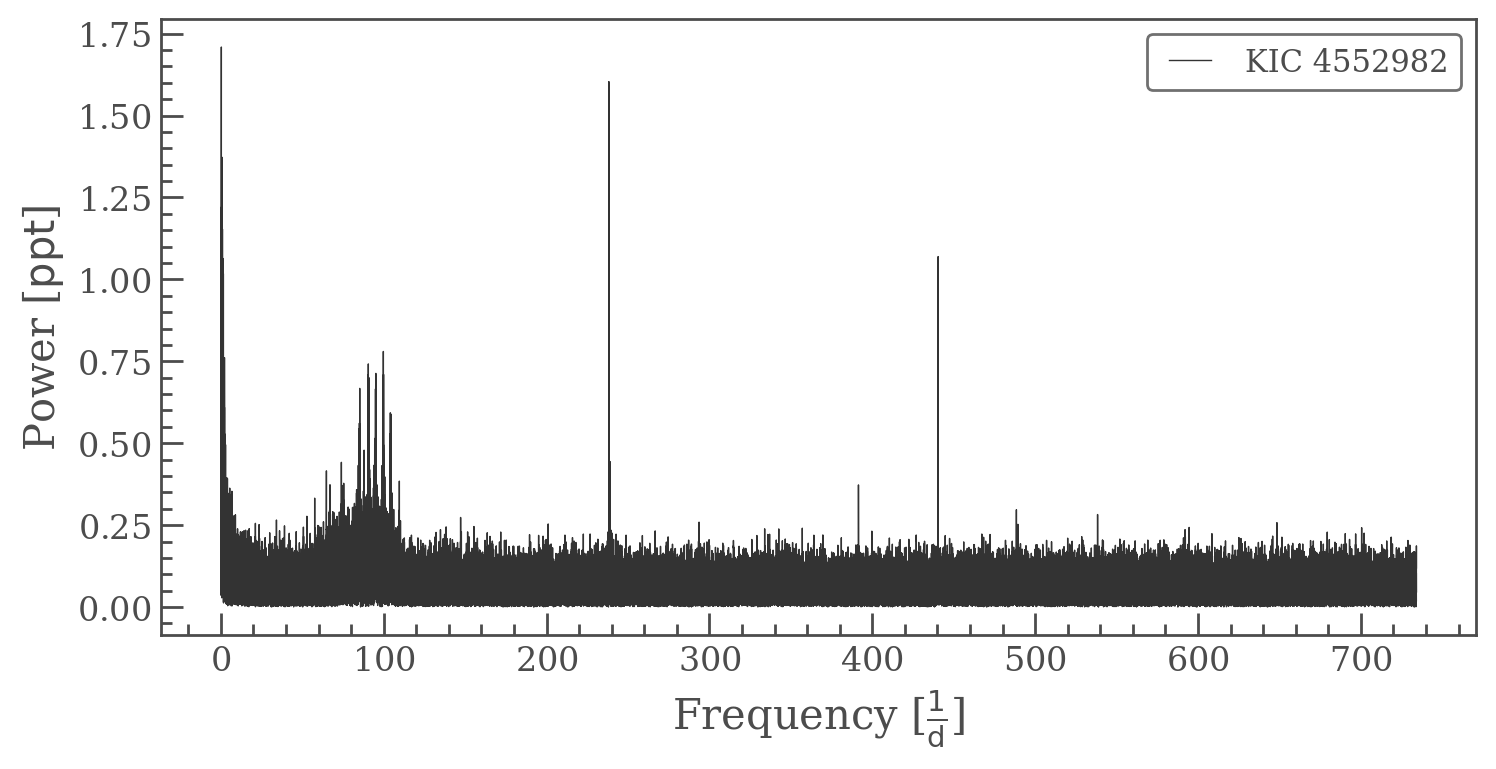

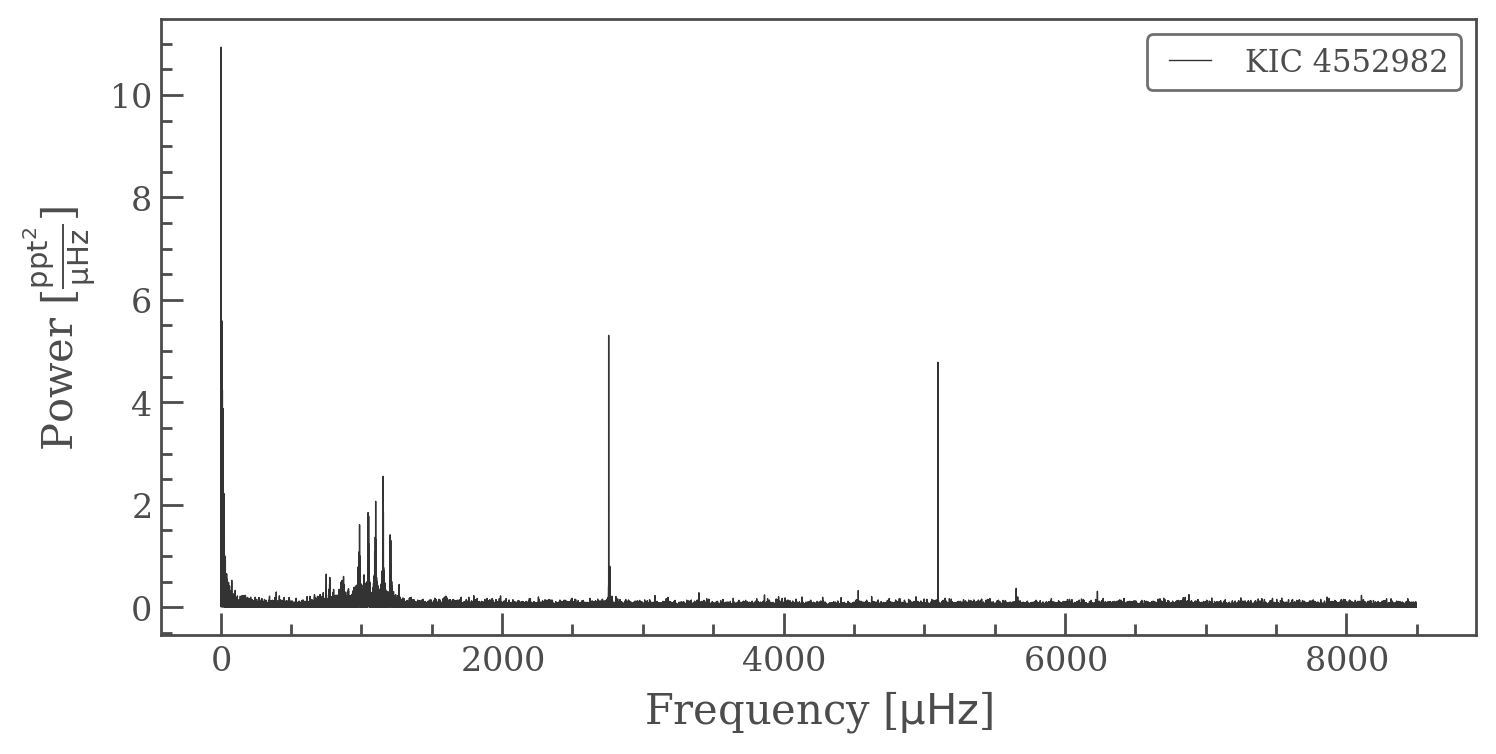

In [7]:
pg = lc.normalize(unit = 'ppt').to_periodogram()#normalization = 'psd')
pg.plot();
pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd')
pg.plot();
# pg = lc.normalize(unit = 'ppt')

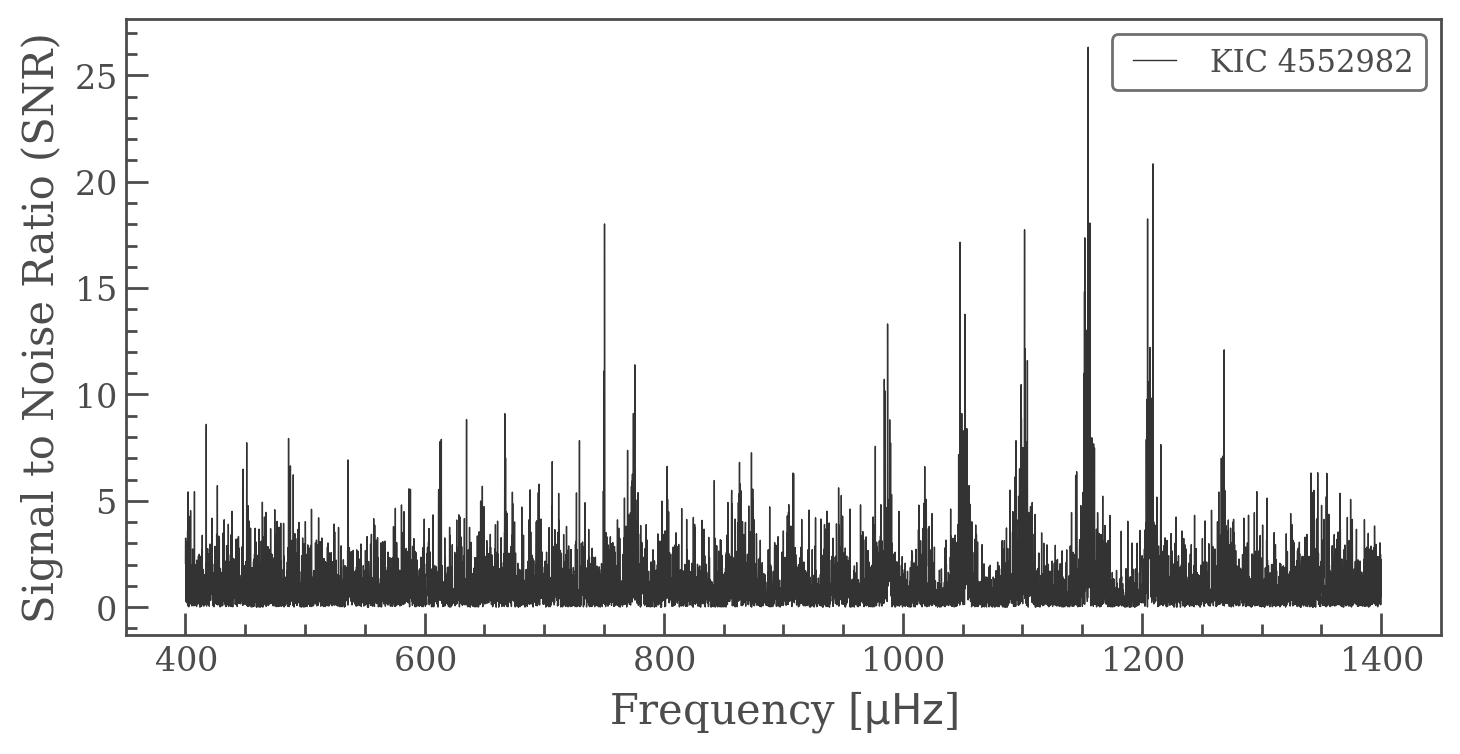

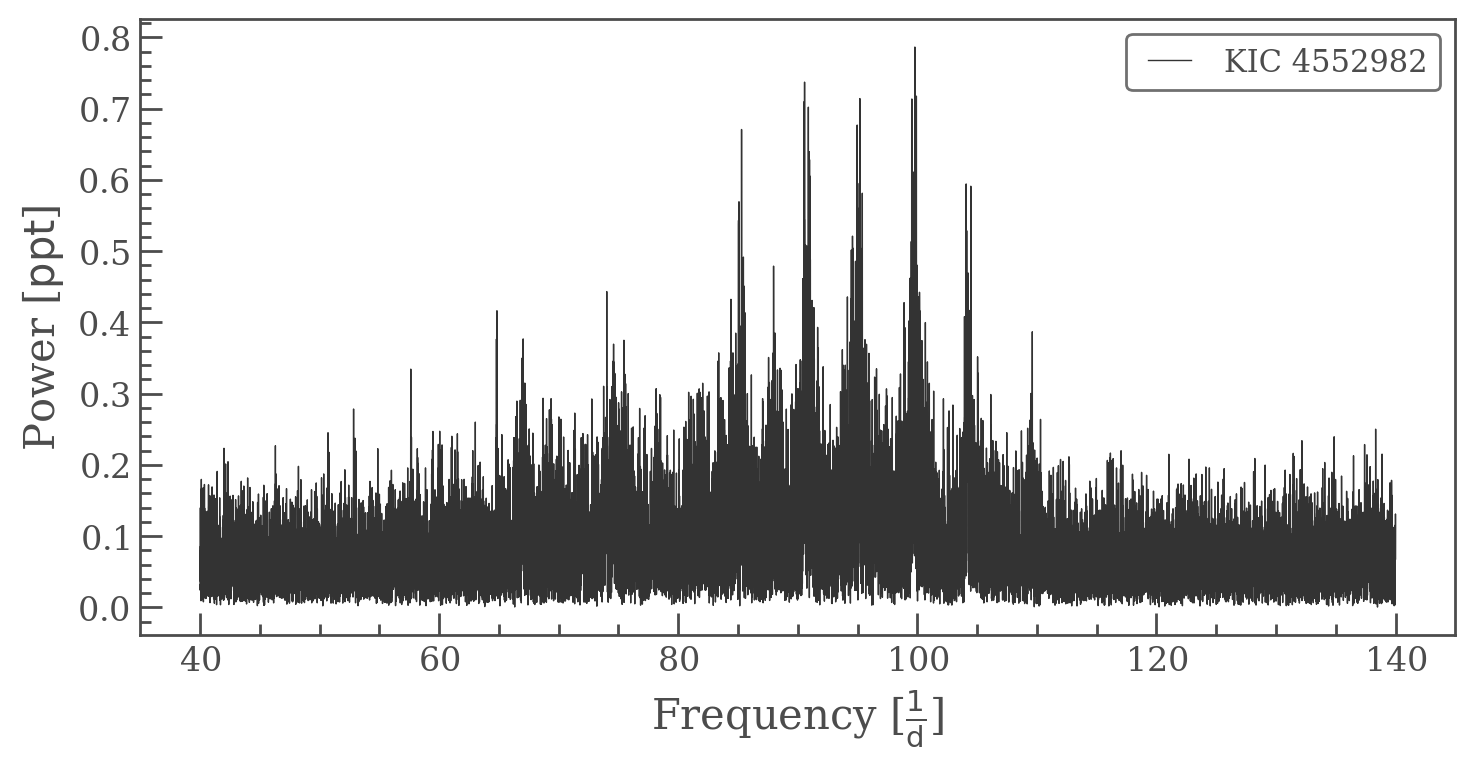

In [8]:
zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd', 
                                                    minimum_frequency = 400, 
                                                    maximum_frequency = 1400).flatten()
zoom_pg.plot()
zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(minimum_frequency = 40, 
                                                    maximum_frequency = 140)#.flatten()
zoom_pg.plot();

In [9]:
seismology = zoom_pg.to_seismology()

/Users/surendrabhattarai/anaconda3/envs/juliet-env/lib/python3.11/site-packages/lightkurve/seismology/core.py:77: LightkurveWarning: Seismology received a periodogram which does not appear to have been background-corrected. Please consider calling `periodogram.flatten()` prior to extracting seismological parameters.
  warnings.warn(


In [10]:
seismology.estimate_numax()

numax: 97.46 1 / d (method: ACF2D)

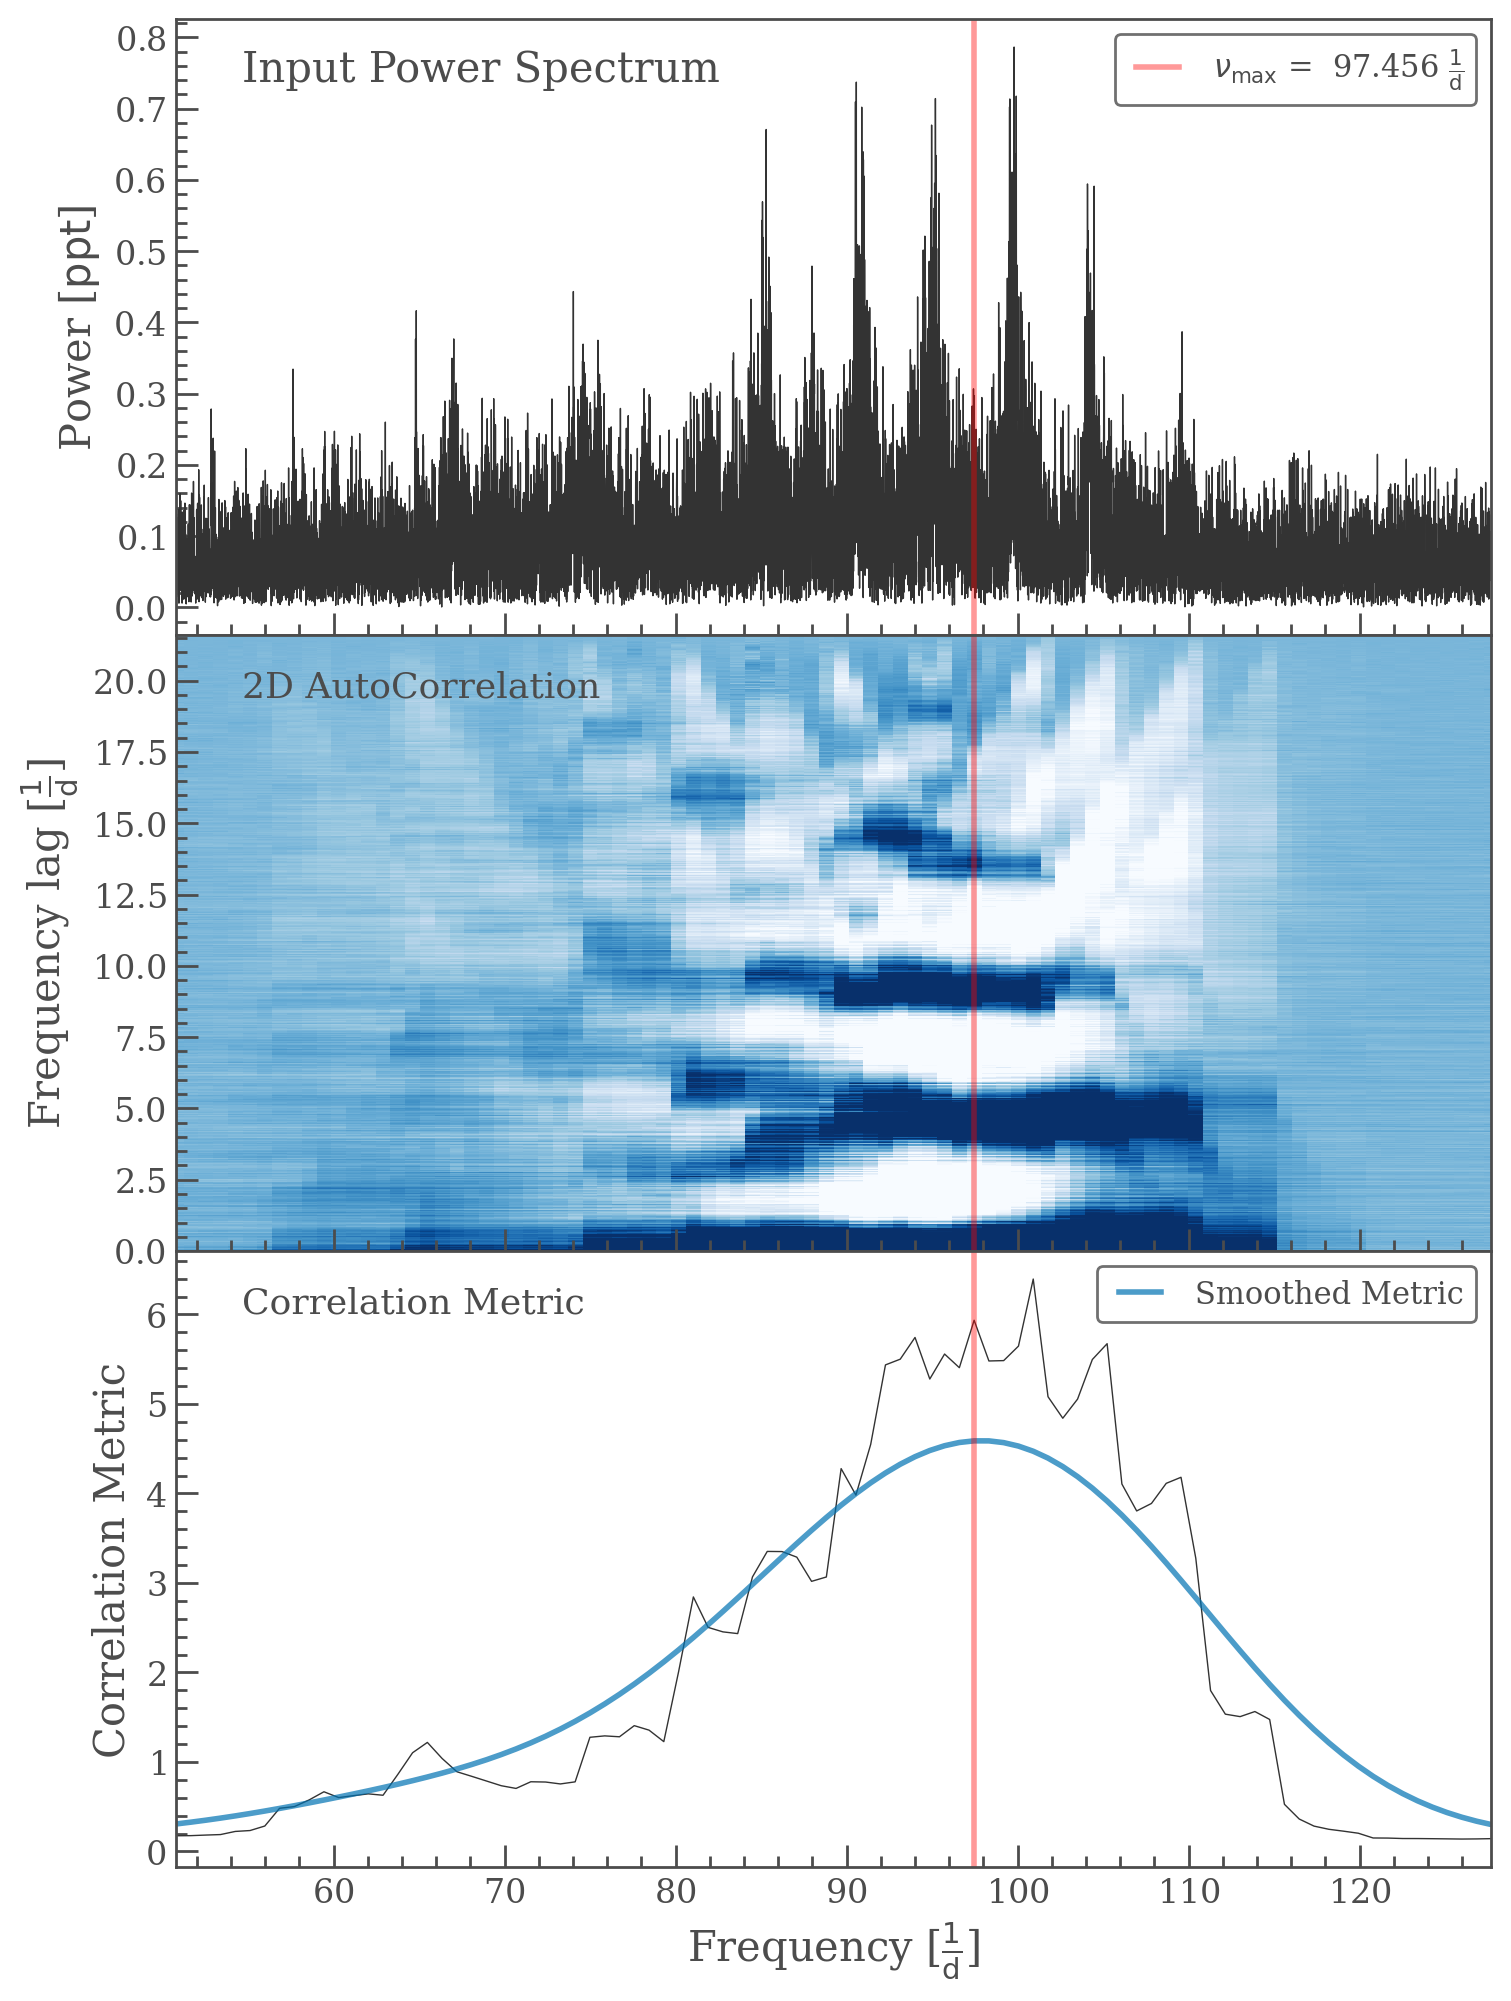

In [11]:
seismology.diagnose_numax();

In [12]:
seismology.estimate_deltanu()

deltanu: 4.56 1 / d (method: ACF2D)

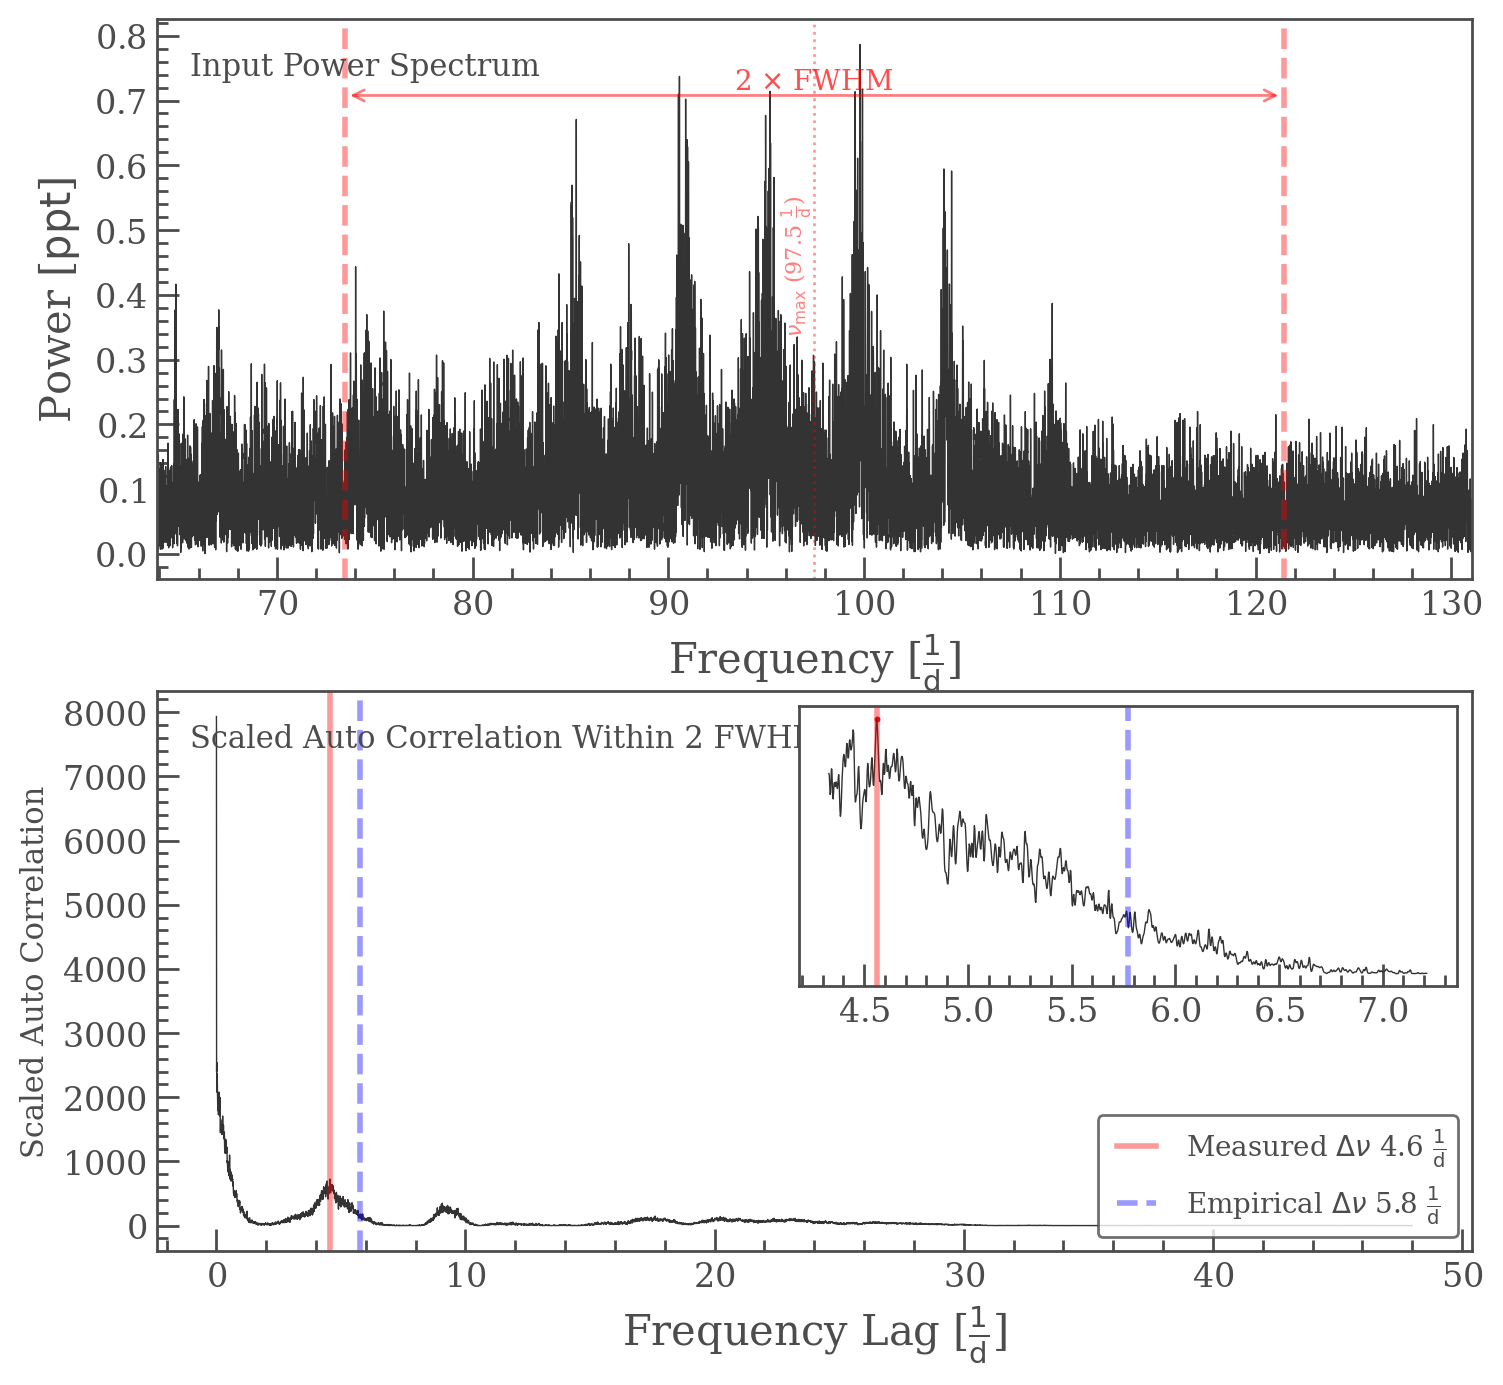

In [13]:
seismology.diagnose_deltanu();

In [13]:
# seismology.estimate_mass()

In [14]:
# seismology.estimate_radius()

In [15]:
# seismology.estimate_logg()

In [16]:
seismology

Seismology(ID: KIC 4552982) - computed values:
 * numax: 97.46 1 / d (method: ACF2D)
 * deltanu: 4.56 1 / d (method: ACF2D)

,nu0_uHz,HWHM_uHz,Height_ppt2
0,775.226919,2.871873,0.128175
1,855.702505,0.766318,0.054765
2,865.425063,11.420597,0.097083
3,907.411509,3.327365,0.053052
4,986.280000,5.054374,0.286794
5,1018.173181,3.210794,0.112822
6,1050.925198,4.840220,0.456824
7,1100.308382,5.798886,0.375842
8,1154.693224,3.455567,0.594766
9,1206.205858,2.988618,0.331327


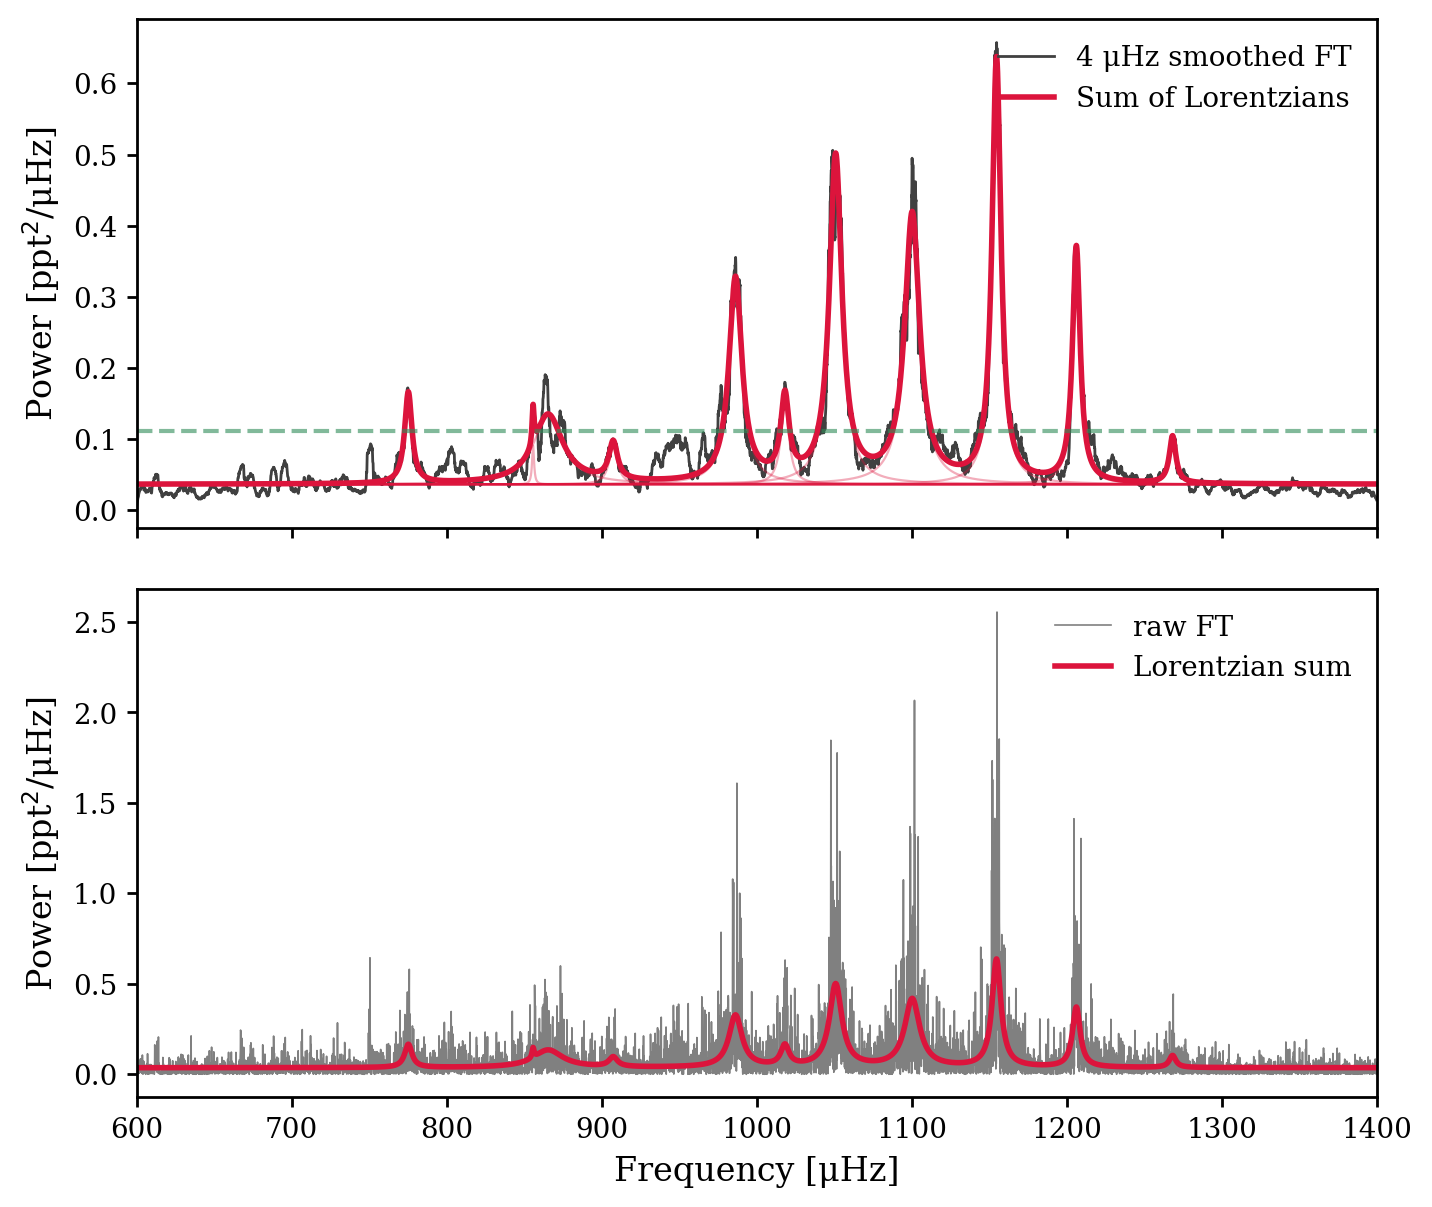

In [14]:
f = pg.frequency.to(u.uHz).value
P = pg.power.value
band = (f >= 600) & (f <= 1400)
f, P = f[band].astype(float), P[band].astype(float)

# resolution → needed for kernels & "distance" in peaks
df = np.median(np.diff(f))

# ================== 2) 4 μHz boxcar (for peak finding only) ==================
def smooth_boxcar(y, width_uHz):
    w = max(3, int(round(width_uHz/df)))
    k = np.ones(w) / w
    return np.convolve(y, k, mode="same")

P_s = smooth_boxcar(P, 4.0)

# ================== 3) Lorentzian model (on POWER) ==================
def lorentzian(fr, H, nu0, gamma):
    # single component (no baseline)
    return H / (1.0 + ((fr - nu0) / gamma) ** 2)

def lorentz_sum(fr, C, *params):
    # params = [H1,nu1,g1, H2,nu2,g2, ...]
    tot = C * np.ones_like(fr)
    for H, nu, g in np.array(params).reshape(-1, 3):
        tot += lorentzian(fr, H, nu, g)
    return tot

# ================== 4) Seed peaks robustly ==================
# use prominence, not absolute height; take top K by prominence
prom_base = np.percentile(P_s, 95)
pk, props = find_peaks(P_s,
                       prominence=0.25*prom_base,            # robust
                       distance=max(1, int(round(6.0/df))))  # ≥6 μHz apart
if pk.size == 0:  # fallback slightly looser
    pk, props = find_peaks(P_s, prominence=0.15*prom_base,
                           distance=max(1, int(round(5.0/df))))

Kmax = 12
order = np.argsort(props["prominences"])[::-1][:Kmax]
pk = pk[order]

seed_centers = f[pk]
# estimate widths from the smoothed peak shapes
w_res = peak_widths(P_s, pk, rel_height=0.5)[0] * df       # FWHM in μHz
seed_widths = np.clip(0.5 * w_res, 0.4, 6.0)               # HWHM initial
seed_heights = np.clip(P_s[pk] - np.median(P_s), 1e-4, None)

# ================== 5) Fit on the *smoothed* spectrum ==================
C0 = np.percentile(P_s, 10)
theta0 = [C0]
lo, hi = [0.0], [np.inf]
for H, nu, g in zip(seed_heights, seed_centers, seed_widths):
    theta0 += [H, nu, g]
    lo     += [0.0, nu - 4.0, 0.2]      # conservative bounds
    hi     += [np.inf, nu + 4.0, 12.0]

popt, pcov = curve_fit(lorentz_sum, f, P_s, p0=theta0,
                       bounds=(lo, hi), maxfev=200000)

# unpack for a tidy table (optional)
Cfit = popt[0]
pars  = np.array(popt[1:]).reshape(-1, 3)
fit_tab = pd.DataFrame(
    dict(nu0_uHz=pars[:,1], HWHM_uHz=pars[:,2], Height_ppt2=pars[:,0])
).sort_values("nu0_uHz").reset_index(drop=True)
display(fit_tab.head(20))

# ================== 6) Plots ==================
fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True,
                                     gridspec_kw=dict(hspace=0.12))

# TOP: smoothed FT + model + components
ax_top.plot(f, P_s, color="0.25", lw=1.0, label="4 μHz smoothed FT")
ax_top.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Sum of Lorentzians")

# draw each component cleanly (no baseline in the component curve)
for H, nu, g in pars:
    ax_top.plot(f, Cfit + lorentzian(f, H, nu, g), color="crimson", lw=0.8, alpha=0.35)

# a simple significance proxy (green dashed)
quiet = (f < 700) | (f > 1350)
sig = 4.0 * np.median(P_s[quiet])
ax_top.axhline(sig, ls="--", color="seagreen", alpha=0.6)

ax_top.set_ylabel("Power [ppt$^2$/μHz]")
ax_top.set_xlim(600, 1400)
ax_top.legend(frameon=False, loc="upper right")

# BOTTOM: raw FT with the same fitted sum drawn over it
ax_bot.plot(f, P, color="0.5", lw=0.6, label="raw FT")
ax_bot.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Lorentzian sum")
ax_bot.set_xlabel("Frequency [μHz]")
ax_bot.set_ylabel("Power [ppt$^2$/μHz]")
ax_bot.legend(frameon=False, loc="upper right")
plt.show()

In [15]:
assert ('f' in globals()) and ('P' in globals())

# Convert x-axis to period (seconds) and sort by increasing period
Psec = 1e6 / f               # P = 1/f; f in µHz → P in s
order = np.argsort(Psec)     # growing period
Psec  = Psec[order]
Ppow  = P[order]

# Uniform period grid (paper: ~667–2000 s lives inside 600–1500 µHz)
Pmin, Pmax, dP = 700.0, 1700.0, 0.5   # step ~0.5 s is fine
Pgrid = np.arange(Pmin, Pmax + dP/2, dP)
Ygrid = np.interp(Pgrid, Psec, Ppow)  # FT re-sampled in (period, power)

**Period transform of the period transform → peak at ΔP**

We look for a periodicity in the period domain, i.e., regular spacing. A robust way is to FFT the period-domain curve and convert FFT frequency to a spacing in seconds, then pick the biggest peak in a sensible range.

In [16]:
# Detrend & window to keep leakage in check
y = Ygrid - np.median(Ygrid)
w = np.hanning(y.size)
yw = y * w

# FFT in the period domain (independent variable is 'period' with step dP)
F = np.fft.rfft(yw)
nu_prime = np.fft.rfftfreq(yw.size, d=dP)     # cycles per second-of-period
power_PT = (F.real**2 + F.imag**2)

# Convert ν' to a spacing in seconds: ΔP = 1 / ν'
with np.errstate(divide='ignore'):
    spacing_s = 1.0 / nu_prime
mask = (spacing_s >= 10.0) & (spacing_s <= 100.0)  # DAVs: ~15–60 s typical; adjust if needed

# Find peak near the expected ΔP (and its harmonic will appear at ~ΔP/2)
pk, props = find_peaks(power_PT[mask], prominence=np.percentile(power_PT[mask], 90)/4)
best = pk[np.argmax(power_PT[mask][pk])] if pk.size else np.argmax(power_PT[mask])
DeltaP = float(spacing_s[mask][best])

print(f"Estimated ΔP ≈ {DeltaP:.2f} s")

Estimated ΔP ≈ 47.64 s


Similar to fig. 12, 13 of [KIC 4552982: OUTBURSTS AND ASTEROSEISMOLOGY FROM THE LONGEST PSEUDO-CONTINUOUS LIGHT CURVE OF A ZZ Ceti](https://iopscience.iop.org/article/10.1088/0004-637X/809/1/14#apj516870t2):

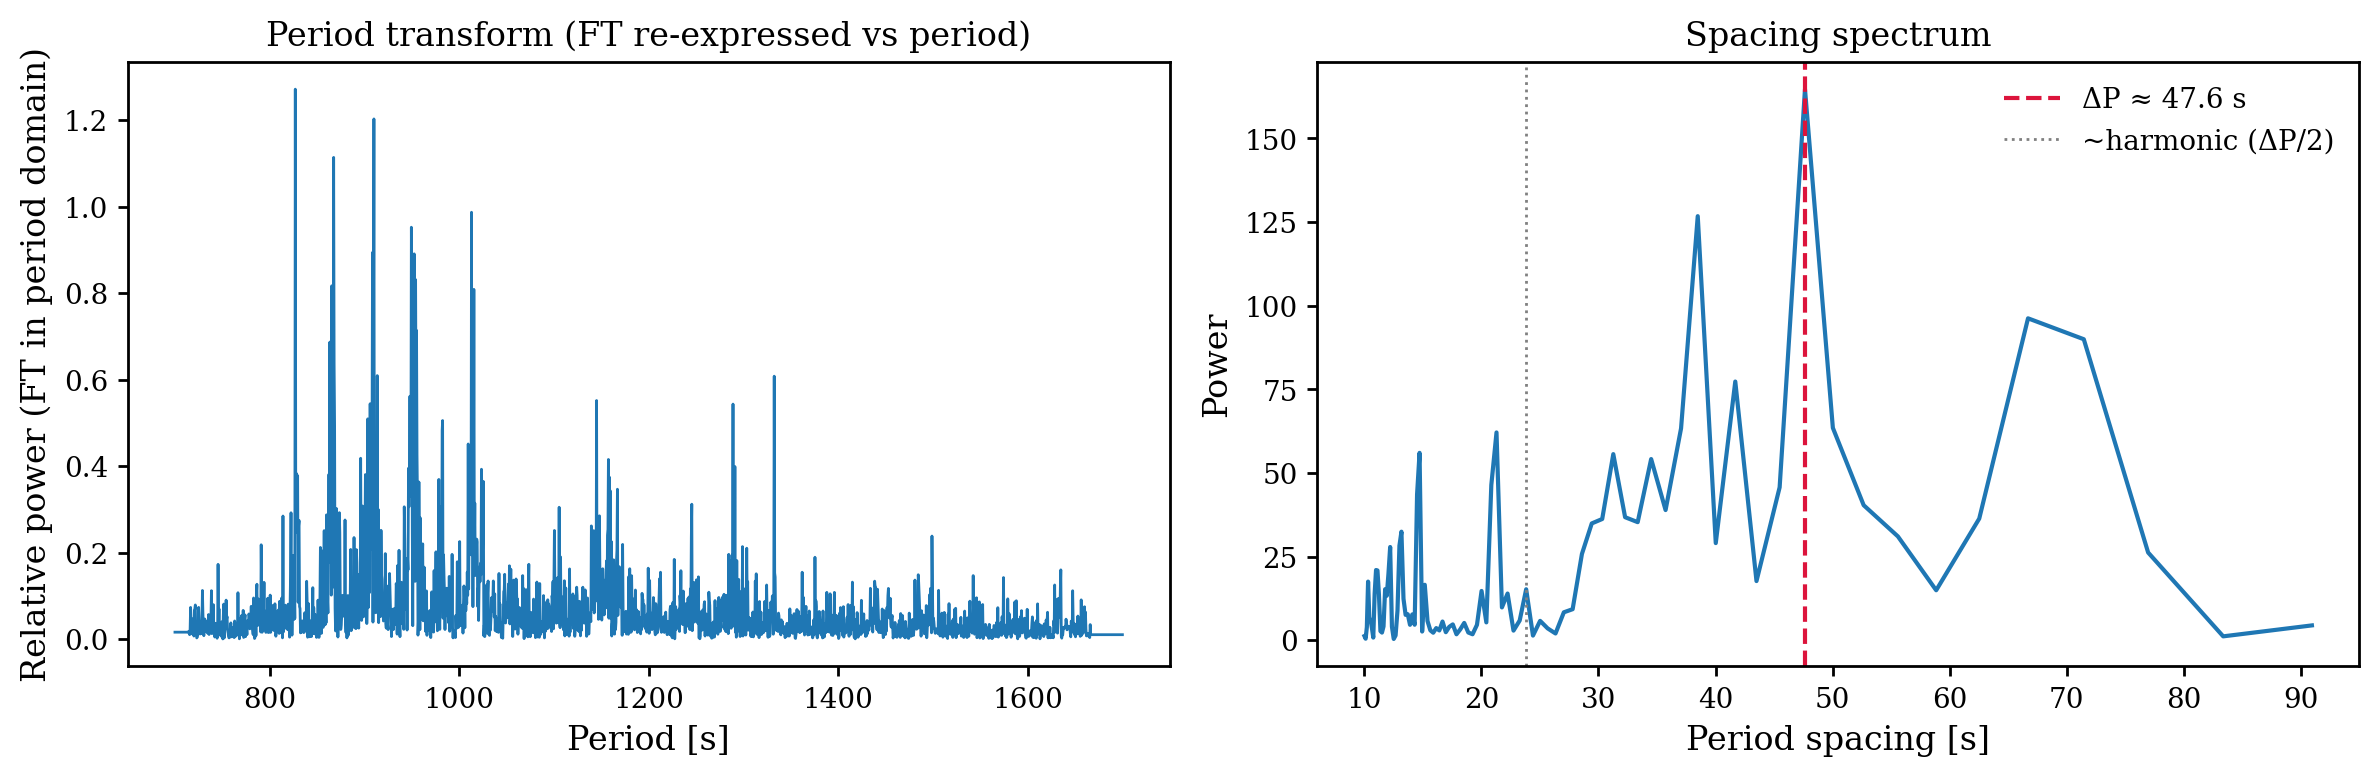

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Left: period transform (FT vs period)
ax[0].plot(Pgrid, Ygrid, color='tab:blue', lw=1)
ax[0].set_xlabel("Period [s]")
ax[0].set_ylabel("Relative power (FT in period domain)")
ax[0].set_title("Period transform (FT re-expressed vs period)")

# Right: "period transform of period transform" → peak at ΔP
ax[1].plot(spacing_s[mask], power_PT[mask], color='tab:blue')
ax[1].axvline(DeltaP, color='crimson', ls='--', lw=1.5, label=fr"ΔP ≈ {DeltaP:.1f} s")
ax[1].axvline(0.5*DeltaP, color='gray', ls=':', lw=1, label="~harmonic (ΔP/2)")
ax[1].set_xlabel("Period spacing [s]")
ax[1].set_ylabel("Power")
ax[1].set_title("Spacing spectrum")
ax[1].legend(frameon=False)
plt.tight_layout()
plt.show()


Better band + whitening in the period domain

In [19]:
# --- FT → period domain (same arrays you plotted) ---
f_uHz = pg.frequency.to(u.uHz).value          # [µHz]
Ppow  = pg.power.value                        # [ppt^2/µHz]
Psec  = 1e6 / f_uHz                           # period [s]

# focus on DAV g-mode region first (you can tweak bounds later)
m_band = (Psec >= 700) & (Psec <= 1600)
Pgrid  = Psec[m_band]
Ygrid  = Ppow[m_band]

# sort by increasing period (safety)
o = np.argsort(Pgrid)
Pgrid, Ygrid = Pgrid[o], Ygrid[o]

# --- whiten (subtract a slow baseline in period domain) ---
# 80 s running-median is a good start; keeps peaks, removes tilt
dP   = np.median(np.diff(Pgrid))
w80  = max(5, 2*int(round(80.0/dP)//2)+1)     # odd kernel size
Bper = median_filter(Ygrid, size=w80, mode="nearest")
Yw   = np.clip(Ygrid - Bper, 0, None)         # whitened power ≥ 0

# if you want to tighten to the densest band automatically (optional):
# pick contiguous window of width ~520 s maximizing total whitened power
W = 520.0
starts = np.arange(Pgrid.min(), Pgrid.max()-W, 5.0)
score = []
for s in starts:
    m = (Pgrid>=s) & (Pgrid<=s+W)
    score.append(Yw[m].sum())
P_lo = starts[int(np.argmax(score))]
P_hi = P_lo + W
m_tight = (Pgrid>=P_lo) & (Pgrid<=P_hi)
P_use, Y_use = Pgrid[m_tight], Yw[m_tight]

print(f"Using period window: {P_lo:.0f}–{P_hi:.0f} s  (ΔP grid step ≈ {np.median(np.diff(P_use)):.2f} s)")

Using period window: 780–1300 s  (ΔP grid step ≈ 0.11 s)


Suppress obvious combination peaks before spacing analysis

In [20]:
T_days = lc.time.jd.max() - lc.time.jd.min()
rayleigh_uHz = 1e6 / (T_days*86400.0)
tol = max(rayleigh_uHz, 0.5)   # conservative µHz tolerance

# modest smoothing to pick stable FT peaks
df = np.median(np.diff(f_uHz))
k  = max(3, int(round(3.0/df)))
sm = np.convolve(Ppow, np.ones(k)/k, mode="same")

# seed peaks in 600–1400 µHz band
m_ft = (f_uHz>=600) & (f_uHz<=1400)
pk, prop = find_peaks(sm[m_ft], prominence=np.percentile(sm[m_ft], 97)*0.15,
                      distance=int(round(0.8/df)))
fpk = f_uHz[m_ft][pk]  # candidate independent frequencies

# drop harmonics (2fi) and pair sums (fi+fj)
drop = set()
for i in range(len(fpk)):
    # harmonics
    h  = 2.0*fpk[i]
    kH = np.where(np.abs(fpk - h) < tol)[0]
    drop.update(kH.tolist())
    # pair sums
    for j in range(i+1, len(fpk)):
        s  = fpk[i] + fpk[j]
        kS = np.where(np.abs(fpk - s) < tol)[0]
        drop.update(kS.tolist())

keep_idx   = [i for i in range(len(fpk)) if i not in drop]
f_indep    = np.sort(fpk[keep_idx])
P_indep    = 1e6 / f_indep                          # periods [s]
P_indep    = P_indep[(P_indep>=P_lo) & (P_indep<=P_hi)]

print(f"Kept {len(P_indep)} independent periods after combo cull (tol={tol:.2f} µHz).")

Kept 26 independent periods after combo cull (tol=0.50 µHz).


ΔP with an uncertainty (quick bootstrap)

In [43]:
def spacing_spectrum_phaseopt(P, dP_grid, phase_bins=61, sigma_hit=2.0):
    """
    Comb score with phase optimization.
    For each trial spacing dP, maximize score over phase φ ∈ [0,dP).
    Score = sum exp(-(distance_to_nearest_tooth / sigma_hit)^2).
    Returns: scores (phase-optimized), best_dP, best_phase.
    """
    P = np.asarray(P, float)
    Pmin, Pmax = P.min(), P.max()
    scores = np.empty_like(dP_grid, dtype=float)
    best_phases = np.empty_like(dP_grid, dtype=float)

    for j, dP in enumerate(dP_grid):
        # try multiple phases across [0, dP)
        phases = np.linspace(0, dP, phase_bins, endpoint=False)
        best_s, best_phi = -np.inf, 0.0
        for phi in phases:
            # tooth centers in [Pmin, Pmax]
            kmin = int(np.floor((Pmin - phi)/dP)) - 1
            kmax = int(np.ceil((Pmax - phi)/dP)) + 1
            teeth = phi + dP * np.arange(kmin, kmax+1)
            mask  = (teeth >= Pmin) & (teeth <= Pmax)
            teeth = teeth[mask]
            # distance of each P to nearest tooth
            d = np.min(np.abs(P[:, None] - teeth[None, :]), axis=1)
            s = np.exp(-(d / sigma_hit)**2).sum()
            if s > best_s:
                best_s, best_phi = s, phi
        scores[j] = best_s
        best_phases[j] = best_phi

    j_best = int(np.argmax(scores))
    return scores, float(dP_grid[j_best]), float(best_phases[j_best])

# ----- run the spacing spectrum with ℓ=1-focused range -----
dP_grid = np.linspace(30.0, 55.0, 301)     # aim at ℓ=1; widen if needed
S, dP_best, phi_best = spacing_spectrum_phaseopt(P_indep, dP_grid, phase_bins=81, sigma_hit=2.0)

# ----- promote subharmonic to fundamental if appropriate -----
def promote_if_subharmonic(dP_best, S, dP_grid, factor=2.0, ratio=0.6):
    """If best is <30 s, check 2×dP_best; if its score is comparable, promote."""
    if dP_best < 30.0:
        dP2 = dP_best * factor
        idx2 = np.argmin(np.abs(dP_grid - dP2))
        if S[idx2] >= ratio * S[np.argmax(S)]:
            return dP2
    return dP_best

dP_fund = promote_if_subharmonic(dP_best, S, dP_grid)

print(f"Phase-optimized peak: ΔP_best = {dP_best:.1f} s")
print(f"Chosen ΔP (after subharmonic check): {dP_fund:.1f} s")

# ----- quick bootstrap with the new scorer -----
rng = np.random.default_rng(42)
B = 400
boot = []
for _ in range(B):
    resamp = rng.choice(P_indep, size=len(P_indep), replace=True)
    S_b, dP_b, _ = spacing_spectrum_phaseopt(resamp, dP_grid, phase_bins=61, sigma_hit=2.0)
    boot.append(promote_if_subharmonic(dP_b, S_b, dP_grid))

boot = np.array(boot, float)
mu  = np.nanmedian(boot)
sig = 1.4826*np.nanmedian(np.abs(boot - mu))
print(f"ΔP = {mu:.1f} ± {sig:.1f} s  (bootstrap, N={np.isfinite(boot).sum()})")


Phase-optimized peak: ΔP_best = 41.1 s
Chosen ΔP (after subharmonic check): 41.1 s
ΔP = 41.0 ± 3.7 s  (bootstrap, N=400)


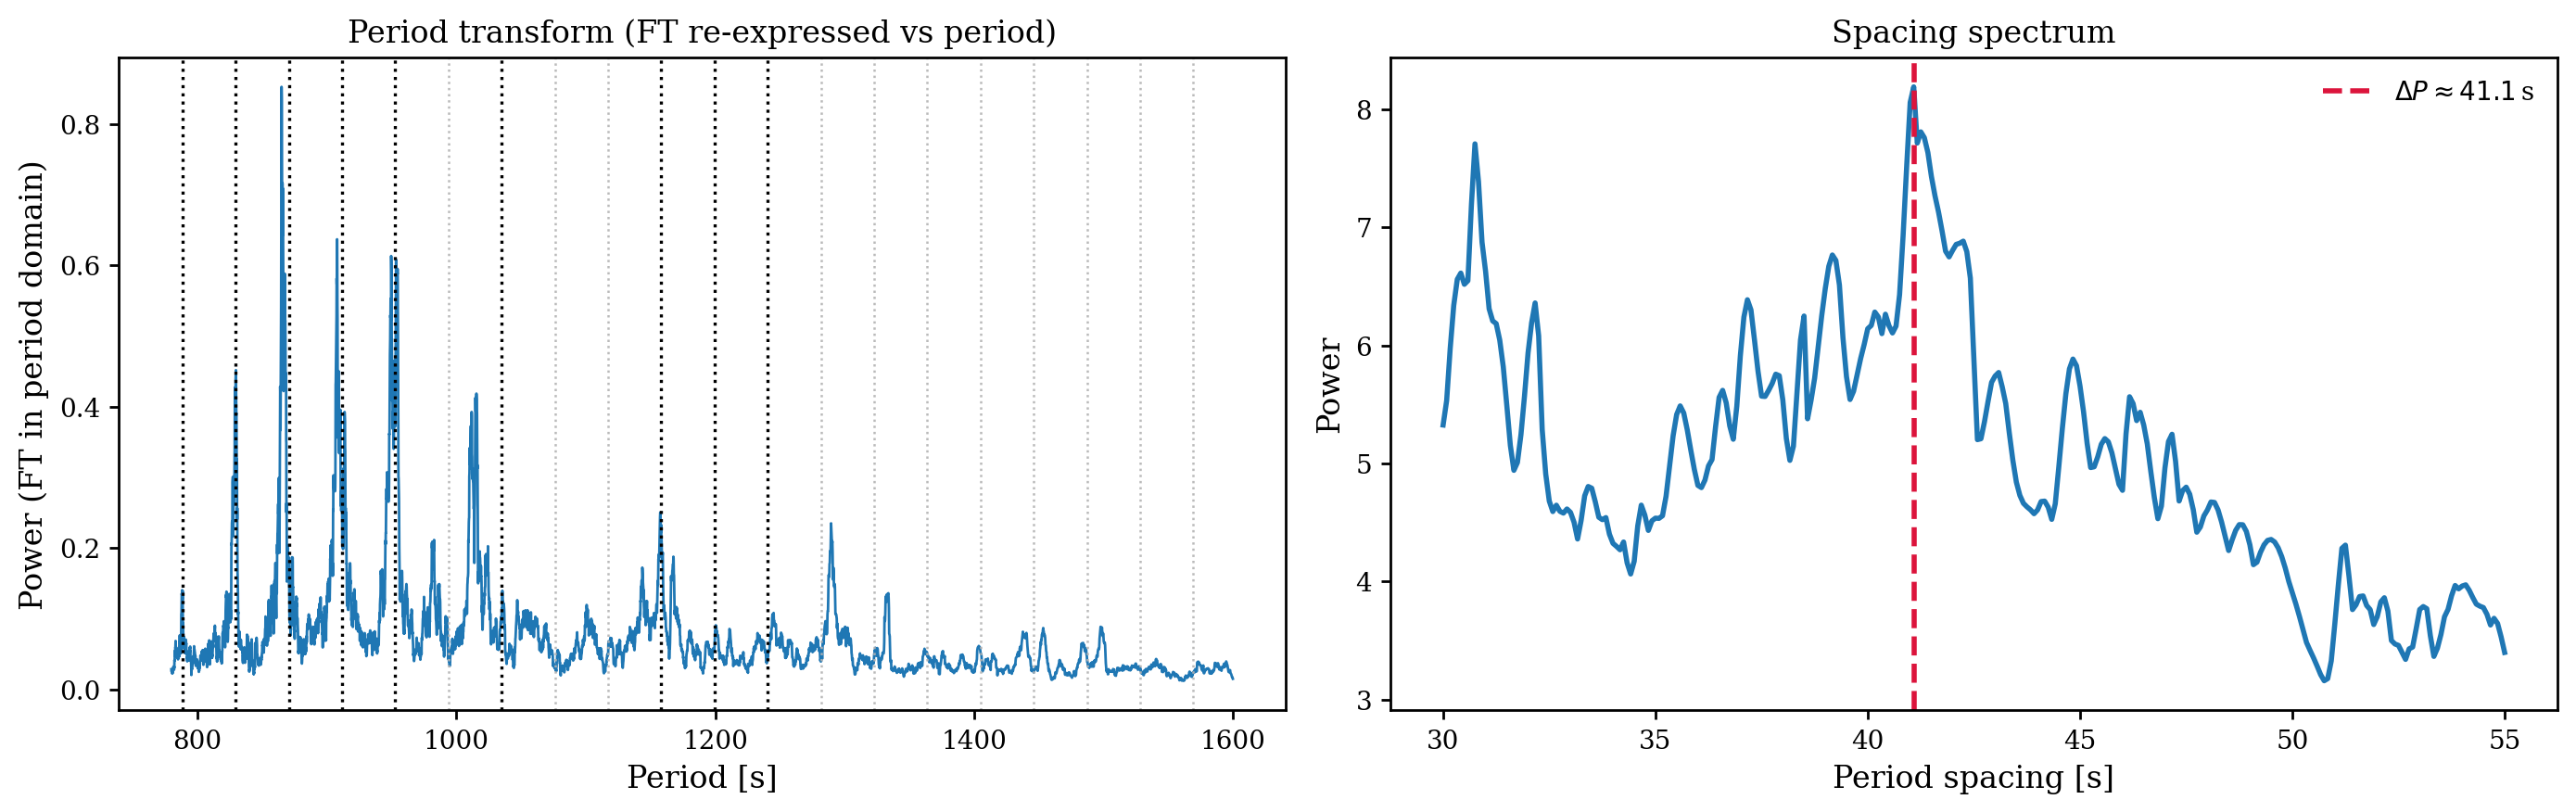

In [45]:
# ---------- 1) Period-domain "FT" (just re-express power vs period and lightly smooth) ----------
per = 1e6 / f                         # seconds
# sort by period so the line looks right
o = np.argsort(per)
per_s = per[o]
Pow_s = P[o]
# optional: very light smoothing in period space (boxcar ~2 s)
dper = np.median(np.diff(per_s))
k_s  = max(3, int(round(2.0/dper)))
Pow_s_sm = uniform_filter1d(Pow_s, size=k_s)

# period axis limits similar to paper; adjust if you want
pmin, pmax = 780.0, 1600.0
mwin = (per_s >= pmin) & (per_s <= pmax)

# ---------- 2) Build expected ℓ=1 comb lines using ΔP_fund and phase (φ) ----------
def refine_phi(P, dP, pmin, pmax, weights=None):
    """Refine phase φ in [pmin, pmin+dP) to best align comb with periods P."""
    P = np.asarray(P, float)
    if weights is None:
        weights = np.ones_like(P)
    # restrict to plotting window
    m = (P >= pmin) & (P <= pmax)
    P = P[m]; W = np.asarray(weights, float)[m]
    if P.size == 0:
        return pmin

    # fine φ grid and robust objective (weighted |distance|)
    phis = np.linspace(pmin, pmin + dP, 2001, endpoint=False)
    scores = np.empty_like(phis)
    for i, phi in enumerate(phis):
        k = np.rint((P - phi)/dP)
        dist = P - (phi + k*dP)
        scores[i] = np.average(np.abs(dist), weights=W)
    j = np.argmin(scores)
    return float(phis[j])

phi_ref = refine_phi(P_indep, dP_fund, pmin, pmax)

def expected_periods(dP, phi, pmin, pmax):
    phi = phi + dP * np.floor((pmin - phi)/dP + 1)     # shift into window
    ks  = np.arange(-500, 500)
    Ps  = phi + ks*dP
    return Ps[(Ps >= pmin) & (Ps <= pmax)]

comb = expected_periods(dP_fund, phi_ref, pmin, pmax)

# darken lines within ±7 s of any kept period (paper convention)
tol_dark = 7.0
is_dark = np.zeros_like(comb, dtype=bool)
for i, Pc in enumerate(comb):
    is_dark[i] = np.min(np.abs(P_indep - Pc)) <= tol_dark

# → re-draw your left panel using 'comb' and 'is_dark'

# ---------- 3) Plot Fig.12-style: period-domain FT with expected ℓ=1 locations ----------
fig, (axL, axR) = plt.subplots(1, 2, figsize=(14, 4.5))

# Left panel (Fig. 12 analogue)
axL.plot(per_s[mwin], Pow_s_sm[mwin], color='tab:blue', lw=1.0)
for x, dark in zip(comb, is_dark):
    axL.axvline(x, color='k' if dark else '0.7',
                lw=1.2 if dark else 0.9, ls=':', alpha=1.0 if dark else 0.9)

# axL.set_xlim(pmin, pmax)
axL.set_xlabel("Period [s]")
# axL.set_ylabel("Relative power (FT in period domain)")
axL.set_ylabel("Power (FT in period domain)")
axL.set_title("Period transform (FT re-expressed vs period)")

# ---------- 4) Plot Fig.13-style: spacing spectrum with ΔP and its harmonic ----------
axR.plot(dP_grid, S, color='tab:blue', lw=2.0)
axR.axvline(dP_fund, color='crimson', ls='--', lw=2.0,
            label=fr"$\Delta P \approx {dP_fund:.1f}\,$s")
# axR.axvline(0.5*dP_fund, color='0.5', ls=':', lw=2.0,
#             label=r"~harmonic ($\Delta P/2$)")

# axR.set_xlim(dP_grid.min(), dP_grid.max())
axR.set_xlabel("Period spacing [s]")
axR.set_ylabel("Power")
axR.set_title("Spacing spectrum")
axR.legend(frameon=False, loc="upper right")

plt.tight_layout()
plt.show()

In [46]:
dP_fund

41.08333333333333

In [18]:
def fit_phase_from_periods(P_meas, dP, Pmin, Pmax):
    """
    Estimate phase P0 so that P_meas ~ P0 + k*dP. Returns P0 in [Pmin,Pmin+dP).
    """
    P_meas = np.asarray(P_meas, float)
    # fractional phase of each period modulo dP
    phi = np.mod(P_meas - Pmin, dP)
    # robust central phase
    # map to angle to avoid wrap issues and take mean angle
    ang = 2*np.pi*phi/dP
    C = np.mean(np.cos(ang)); S = np.mean(np.sin(ang))
    phi0 = (np.arctan2(S, C) % (2*np.pi)) * dP/(2*np.pi)
    P0 = Pmin + phi0
    # place P0 in [Pmin, Pmin + dP)
    if P0 >= Pmin + dP: P0 -= dP
    return P0

def draw_l1_guides(ax, Pgrid, Ygrid, dP, P_meas=None, tol=7.0, color='k'):
    Pmin, Pmax = float(Pgrid.min()), float(Pgrid.max())
    # if you have measured periods, fit a phase; otherwise use the phase that maximizes overlap with Ygrid
    if P_meas is not None and len(P_meas) >= 3:
        P0 = fit_phase_from_periods(P_meas, dP, Pmin, Pmax)
    else:
        # coarse search for P0 that maximizes sampled power at comb positions
        trial = np.linspace(Pmin, Pmin + dP, 200)
        scores = []
        for P0t in trial:
            comb = P0t + dP * np.arange(-50, 200)
            comb = comb[(comb >= Pmin) & (comb <= Pmax)]
            scores.append(np.interp(comb, Pgrid, Ygrid).sum())
        P0 = trial[int(np.argmax(scores))]

    # make all guide positions
    kvals = np.arange(-100, 300)
    Pexp  = P0 + dP * kvals
    Pexp  = Pexp[(Pexp >= Pmin) & (Pexp <= Pmax)]

    # if you have measured periods, mark those guides darker when a period is within ±tol s
    heavy = np.zeros_like(Pexp, dtype=bool)
    if P_meas is not None and len(P_meas):
        Pm = np.asarray(P_meas, float)
        for i, p in enumerate(Pexp):
            if np.min(np.abs(Pm - p)) <= tol:
                heavy[i] = True

    # draw
    for p, is_heavy in zip(Pexp, heavy):
        ax.axvline(p, ls=':', lw=(2.2 if is_heavy else 1.0),
                   color=(color if is_heavy else (0,0,0,0.35)))

    # annotate ΔP and phase
    ax.text(0.01, 0.97, fr"$\Delta P \approx {dP:.1f}\,$s",
            transform=ax.transAxes, ha='left', va='top')

# ---- call it on your existing figure/axes ----
# left panel axis you created for the period-transform:
ax_left = plt.gcf().axes[0]   # or whatever handle you used

# Example measured periods (fill with your detections, or paste Table 2 ℓ=1 candidates in seconds):
measured_periods = [
    1498.32, 1362.95, 1333.18, 1301.73, 1289.21, 1244.73, 1200.18,
    1158.20, 1100.87, 1053.68, 1014.24,  982.23,  950.45,  907.59,
     866.11,  828.29,  788.24
]
# If you only want to use your own found periods, replace the list above with your list.

draw_l1_guides(ax_left, Pgrid, Ygrid, dP_best, P_meas=measured_periods, tol=7.0)
plt.draw()

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>